# dataloaders.py

In [1]:
import sys
sys.path.append("../src")

from dataloaders import encode_label, decode_label



In [2]:
unique_classes = ["a", "b", "c"]
classes = ["a", "b"]

encoded = encode_label(classes, unique_classes)
print(encoded)


unique_classes = ["a", "b", "c"]
classes = ["a", "c"]

encoded = encode_label(classes, unique_classes)
print(encoded)

unique_classes = ["a", "b", "c"]
classes = [""]

encoded = encode_label(classes, unique_classes)
print(encoded)

[1, 1, 0]
[1, 0, 1]
[0, 0, 0]


In [3]:
unique_classes = ["a", "b", "c"]


decoded = decode_label([1, 0, 0], unique_classes)
print(decoded)


decoded = decode_label([1, 1, 0], unique_classes)
print(decoded)


decoded = decode_label([0, 0, 0], unique_classes)
print(decoded)

['a']
['a', 'b']
['']


In [4]:
import sys
sys.path.append("../src")

from dataloaders import ECGDataset

# Example of usage
path = '../data/physionet.org/files/ptb-xl/1.0.2/'
sampling_rate = 100  # or other value depending on your data

dataset = ECGDataset(path, sampling_rate)


[INFO] Loading data...
[INFO] Obtaining diagnostic_superclass ...


In [13]:
print(len(dataset))
print(dataset[0])


17420
245 757
{'x': tensor([[-0.0720, -0.0340,  0.0380,  ..., -0.0100, -0.0190,  0.0230],
        [-0.0560,  0.0180,  0.0750,  ..., -0.0150, -0.0210,  0.0200],
        [-0.0640,  0.0090,  0.0730,  ..., -0.0220, -0.0190,  0.0170],
        ...,
        [-0.0340, -0.0740, -0.0400,  ..., -0.0580, -0.0350, -0.0430],
        [-0.0180, -0.0560, -0.0380,  ..., -0.0400, -0.0260, -0.0360],
        [-0.0150, -0.0350, -0.0200,  ..., -0.0460, -0.0220, -0.0300]]), 'y_decoded': ['NORM'], 'y': tensor([0, 0, 0, 0, 1, 0])}


In [6]:
dataset[0]['x'].shape, dataset[0]['y'].shape

22 534
442 954


(torch.Size([512, 12]), torch.Size([6]))

In [1]:
import sys
sys.path.append("../src")

from dataloaders import ECGDataset

ds_train = ECGDataset(
        "../data/data_dumps/sr100/",
        mode="train",
        L=128,
        test_folds=[9],
    )

[INFO] Loading data...


In [2]:
ds_train.X.shape, ds_train.super_classes.shape

((19618, 1000, 12), (19618,))

In [5]:
import numpy as np

np.arange(1,11)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [14]:
from torch.utils.data import DataLoader


# Create a DataLoader
batch_size = 2


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Using the DataLoader in a training loop
for batch in dataloader:
    print(batch['x'].shape, batch['y'].shape)
    print(batch['y'][0])
    break

19719246447    976709559704


349248 
76065294 
 861 
577482321806 

 246243833994
  758755460

47
180234    972559746


692
torch.Size([2, 512, 12]) torch.Size([2, 6])
tensor([0, 0, 0, 0, 1, 0])


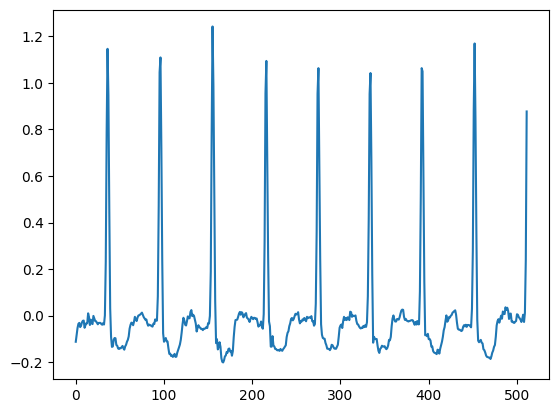

In [12]:
import matplotlib.pyplot as plt

x = batch['x'][0]
plt.plot(x[:, 0])

# augmentations

# models.py

In [1]:
import sys
sys.path.append("../src")


from models import SinusoidalPosEmb




In [3]:
import torch

pos_emb = SinusoidalPosEmb(dim=16)

x = torch.randn(1, 1000)
print(pos_emb(x).shape)

x = torch.randn(1, 1000, 12)
y = pos_emb(x) # (B, T, C) -> (B, T, C, 16)
print(y.shape)
# convert to (B, T, 16*C)
y = y.flatten(-2)
print(y.shape)

# 16*12 -> 192


torch.Size([1, 1000, 16])
torch.Size([1, 1000, 12, 16])
torch.Size([1, 1000, 192])


In [4]:
import sys
sys.path.append("../src")
from models import Extractor
import torch

extractor = Extractor(dim_base=128, dim=384)

x = torch.randn(2, 1000, 12)
y = extractor(x, Lmax=128)
print(y.shape)


627 755
torch.Size([2, 128, 384])


In [2]:
import sys
sys.path.append("../src")
from models import DeepHeartModel
import torch

model = DeepHeartModel()

x = torch.randn(2, 512, 12)
y = model(x)
print(y.shape)


torch.Size([2, 5])


In [3]:
%timeit y = model(x)

129 ms ± 5.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
